# Chapter 7: k Means

In [1]:
%reset
low_memory=False
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from scipy.stats import mode

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


c:\users\kevin\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1.1 Introduction & Motivation

Welcome to the start of the Unsupervised Learning part of this course! If you're reading this, you've succesfully made it to the middle of Data Science Fundamentals. Congratulations!

Now, with the niceties out of the way, let's get started with our very first unsupervised learning problem: **clustering**. First of all, thusfar we've found ourself in a setting where we had both dependent variables and independent variables. We then tried to construct some kind of model which would allow us to predict values of the dependent variable based upon values for the independent variables. In this setting, we always had the value for the value we wanted to predict in our so called training-set. This simplified the process greatly.

In unsupervised learning, we don't have this. We've just got the independent variables and are tasked to for some kind of pattern in them. The concrete question which we'll try to deal with is the trying and finding of clusters.

Illustrations say more than a thousand words:

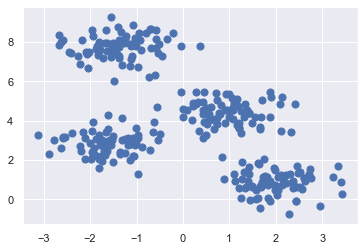

In [2]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

We can clearly see some kind of patter here: there are 4 different clusters of points. It is the goal of cluster analysis to recognize these clusters, and use the model to predict in which cluster the next observation will be.

In comparison with supervised learning, each cluster may correspond to one certain value of the dependent variable in categorization.

## 1.2 Problem Setting

The problem setting we'll use in this chapter is an adapted version of the problem that we've been using in the categorization chapters. We'll once again work with the handwritten digits dataset, only this time we won't be making any use of the provided labels!

In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

As we can see, we've got a dataset of 1797 observations with 64 variables. Our goal is to group our observations in classes, without knowing the labels of our observations. We then hope later on, that these classes correspond to the labels of the numbers.

Right now we are just omitting the labels from our dataset to simulate how unsupervised learning would go, but you should remember this is a setting with which we are confronted a lot of with in the real world.

## 1.3 Model

### 1.3.1 Model

The 𝑘-Means model which we will use for our cluster analysis accepts one hyperparameter, 𝑘. 𝑘 corresponds to the number of clusters we would like to detect. The $k$Means algorithm chooses $k$ random points in our action space, and allocates each observation to the nearest chosen point. These are the first estimates of our clusters. As the initial points were chosen at random these estimates are not yet very good. The next guess is going to be the middle point of each temporary cluster. The same process is then repeated until we can no longer improve our clusters.

In other words:


   1. Guess some cluster centers
   2. Repeat until converged
      a.  E-Step: assign points to the nearest cluster center
      b.  M-Step: set the cluster centers to the mean

An illustration can be seen here:

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)

### 1.3.2 Model Estimation

Luckily, SKLearn makes it really for us to execute this algorithm:

In [4]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

We can see what results from our analysis: 10 observations with 64 variables each. These are the 10 points which are the center of each cluster. If a new point were to appear, it will be allocated (predicted) to the cluster to which it is closest. Let's take a look at the centers of the clusters:

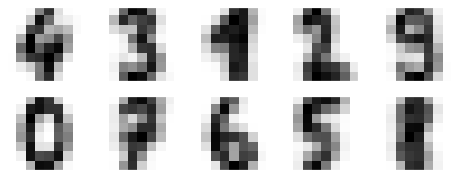

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Optional:

It might be interesting to compare exactly how good our predictions are. To compare it with the actual data, we need to bring our labels back into the mix. Let's do this:

In [6]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

A first metric is simply the accuracy score:

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

It's amazing! Our model has succesfully predicted 80% of all labels! And that purely on the underlying structure, without even looking towards the real labels. The confusion matrix might give us a better view of where the model went wrong:

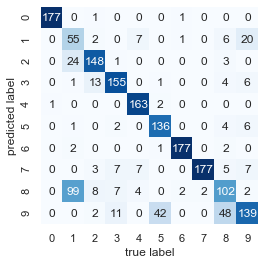

In [8]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names,
           cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label');

The labels which are some times mistaken are:
* 8 is predicted in stead of 1
* 9 is predicted in stead of 5
* 9 is predicted in stead of 8

The latter two are something we can definitely understand looking at the similarity of the numbers 8 to 9 and 5 to 9.

##### Question 1: Why would 8 be predicted in stead of 1? Can you think of an explanation?

### 1.3.4 Model Evaluation

The $k$-Means model which we will use for our cluster analysis accepts one hyperparameter, $k$. $k$ corresponds to the number of clusters we would like to detect. In our case it is obvious that we expect to find 10 clusters (one for each of the numbers going from 0-10). Even if we would have no access to the labels, we would know that we need to find 10 labels. Maybe 11 if there are also not-number images in our dataset. In this case we still have some kind of information about our dependent variable. 

In the real world however, even this isn't the case most of the time. Consider for example the question Netflix posed itself several years ago: can we categorize movies by genre? How many genres are there? Is there a significant difference between action and crime movies? In this case, nothing is known about the labels, and yet we still have to find a certain amount of clusters. How many clusters should we then search for? What is the optimal value of our hyperparameter $k$?

In the case of $k$ means, we will simply fit the model with different values for the parameter, and then compare them.

Above, we have compared our fit to the truth. Often however, we won't have this opportunity. What we can however do, is compute the variance (or distance) between the clusters. The greater this is, the more clear the clusters are.

In [11]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(digits.data)
    distortions.append(kmeanModel.inertia_)

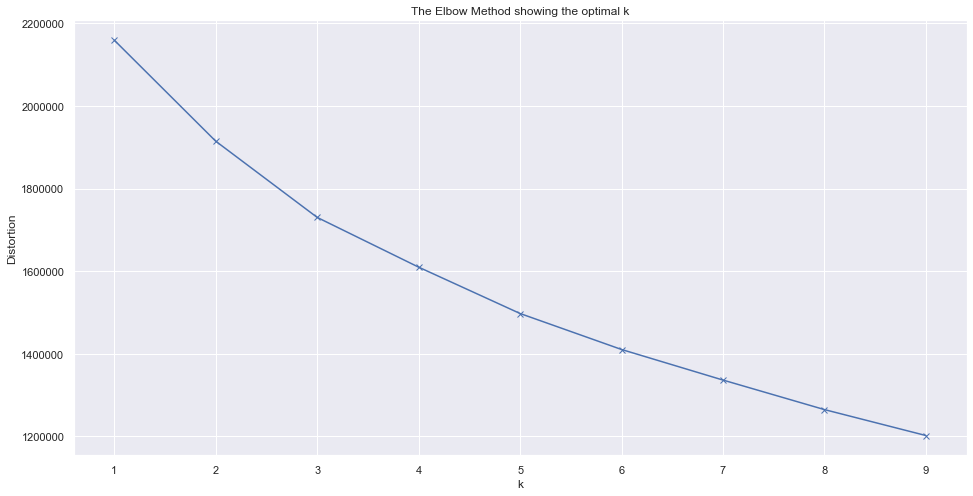

In [12]:
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

The method we have used is called the *Elbow Method*, because normally there should be a kink in the graph, resembling the form of an elbow. Where this elbow is situated, we will find the optimal number of clusters.

##### Question 2: Can you think why there is no elbow to be found here? Fix the code!
##### Question 3: Does your conclusion from the elbow method confirm what we have said before? Explain.

## 1.4 Questions

##### Question 1: See section 1.3.3
##### Question 2: See section 1.3.4
##### Question 3: See section 1.3.4
##### Question 4 + 5: Try to split the dataset in a training and test set like we have done before, and then use the k Means model to predict the values of the test set. Is the model any good? 